In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.68G/3.69G [00:58<00:00, 125MB/s]
100% 3.69G/3.69G [00:58<00:00, 67.4MB/s]


In [3]:
# our dataset is in .zip format. now we will unzip it
import zipfile
zip_ref = zipfile.ZipFile("/content/deep-voice-deepfake-voice-recognition.zip")
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def preprocess_audio(audio_file_path, max_length=500):
    try:

        audio, _ = librosa.load(audio_file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
        if mfccs.shape[1] < max_length:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_length]
        mfccs_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)
        return mfccs_normalized
    except Exception as e:
        print(f"Error was encountered while processing the file: {audio_file_path}")
        return None


def load_data(directory):
    data = []
    labels = []
    for label, folder in enumerate(['REAL', 'FAKE']):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            features = preprocess_audio(file_path)
            if features is not None:
                data.append(features)
                labels.append(label)
    return np.array(data), np.array(labels)


def plot_waveform(audio_file_path, title):
    try:
        audio, sr = librosa.load(audio_file_path, sr=16000)
        plt.figure(figsize=(12, 4))
        plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error encountered while plotting file: {audio_file_path}")

def load_and_plot_waveforms(directory, num_samples=1):
    for label, folder in enumerate(['REAL', 'FAKE']):
        folder_path = os.path.join(directory, folder)
        files = os.listdir(folder_path)
        for i in range(min(num_samples, len(files))):
            file_path = os.path.join(folder_path, files[i])
            plot_waveform(file_path, f'{folder} - {files[i]}')


dataset_dir = "/content/KAGGLE/AUDIO"


train_dir = os.path.join(dataset_dir)
x_train, y_train = load_data(train_dir)

# Check the shapes of the loaded data
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)

Training data shape: (64, 40, 500)
Training labels shape: (64,)


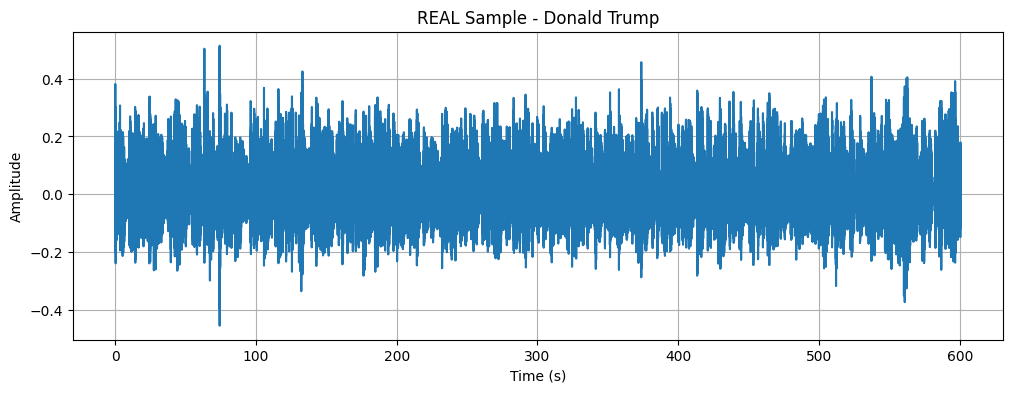

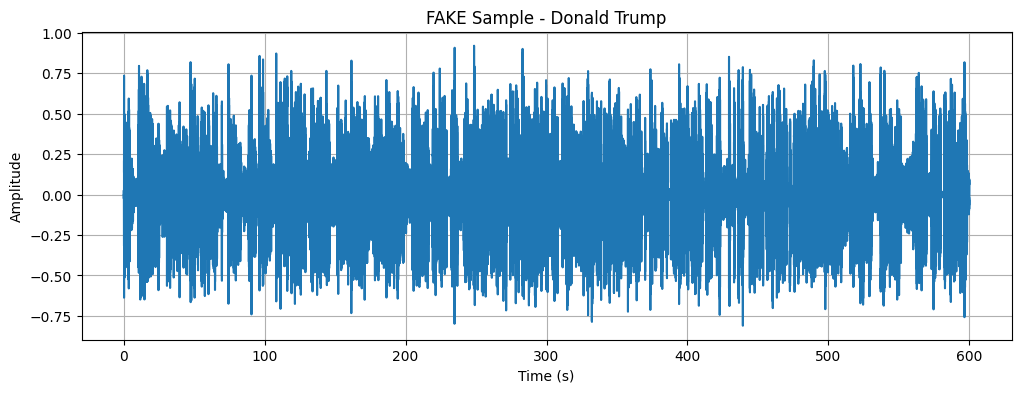

In [5]:
# Paths to specific .wav files

file_path1 = "/content/KAGGLE/AUDIO/REAL/trump-original.wav"
file_path2 = "/content/KAGGLE/AUDIO/FAKE/trump-to-ryan.wav"

# Plot waveforms for the specific files
plot_waveform(file_path1, 'REAL Sample - Donald Trump')
plot_waveform(file_path2, 'FAKE Sample - Donald Trump')

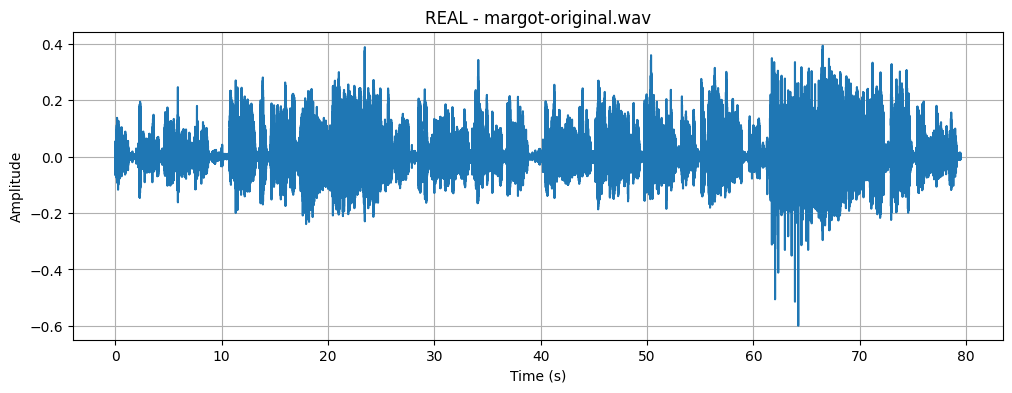

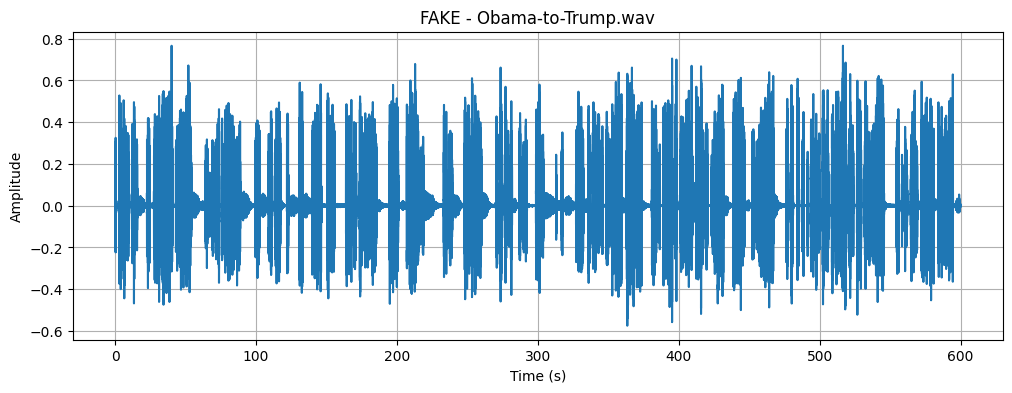

In [6]:

load_and_plot_waveforms(dataset_dir, num_samples=1)

In [15]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# # Define the model
# model = Sequential([
#     Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40, 500)),
#     MaxPooling1D(pool_size=2),
#     BatchNormalization(),
#     Conv1D(filters=128, kernel_size=3, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     BatchNormalization(),
#     LSTM(units=128, return_sequences=True),
#     Dropout(rate=0.5),
#     LSTM(units=128),
#     Dropout(rate=0.5),
#     Dense(units=128, activation='relu'),
#     Dense(units=1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()

# Example: Model with additional layers and regularization
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40, 500), kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(units=128, dropout=0.3, recurrent_dropout=0.3),
    Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(rate=0.5),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 38, 64)              │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 19, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401,345 (1.53 MB)

 Trainable params: 400,961 (1.53 MB)

 Non-trainable params: 384 (1.50 KB)

In [16]:
# Train the model
Model = model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5729 - loss: 3.9436
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8021 - loss: 3.7607
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8438 - loss: 3.5758
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8646 - loss: 3.3539
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.8854 - loss: 3.1771
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8854 - loss: 3.0262
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.8646 - loss: 2.9409
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8646 - loss: 2.7666
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8958 - loss: 2.5733
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8854 - loss: 2.4495
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9688 - loss: 2.3215
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9896 - loss: 

In [17]:

# Evaluate the model
loss, accuracy = model.evaluate(x_train, y_train)
print("Training Loss:", loss)
print("Training Accuracy:", accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9896 - loss: 1.7875
Training Loss: 1.796506643295288
Training Accuracy: 0.984375


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 


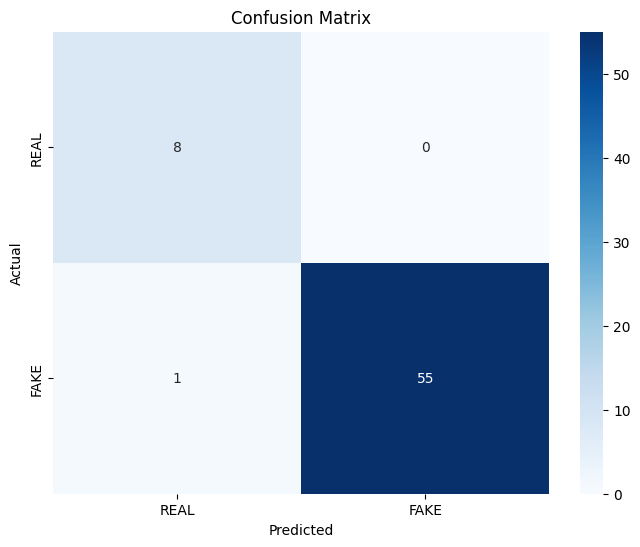

In [18]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
# Generate predictions and probabilities
y_pred_prob = model.predict(x_train)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

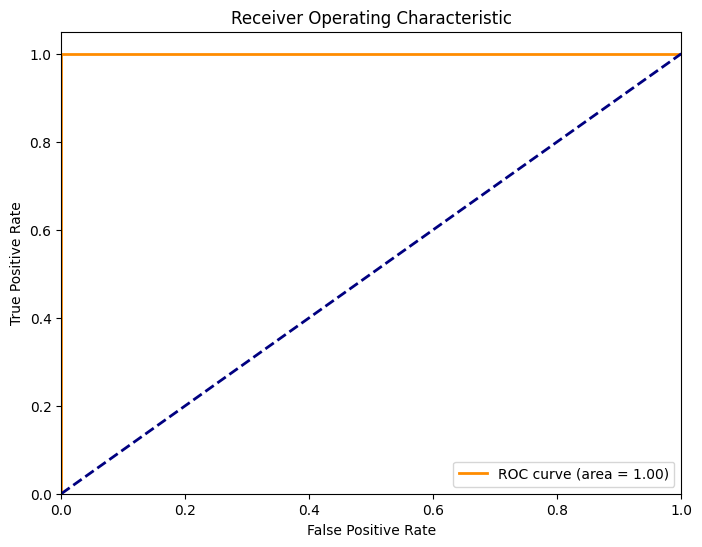

In [19]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
import librosa
import numpy as np

def preprocess_audio(audio_file_path, max_length=500):
    try:
        # Load audio file
        audio, _ = librosa.load(audio_file_path, sr=16000)
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
        # Pad or trim MFCCs to ensure a consistent shape
        if mfccs.shape[1] < max_length:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_length]
        # Normalize MFCC features
        mfccs_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)
        return mfccs_normalized
    except Exception as e:
        print(f"Error encountered while processing file: {audio_file_path}")
        return None

def predict(audio_file_path, model, threshold=0.5):
    # Preprocess the audio file
    processed_audio = preprocess_audio(audio_file_path)
    if processed_audio is not None:
        # Reshape the input for the model
        input_data = np.expand_dims(processed_audio, axis=0)
        # Make predictions
        prediction = model.predict(input_data)
        # Determine class based on threshold
        if prediction >= threshold:
            return "FAKE"
        else:
            return "REAL"
    else:
        return None

# Example usage
audio_file_path = "/content/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav"
prediction = predict(audio_file_path, model)
print("Prediction:", prediction)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
Prediction: FAKE


In [21]:
# Save the model
model.save("model-deepfake-audio-detection.h5")